<a href="https://colab.research.google.com/github/guy-977/x-ray-pneumonia/blob/main/Disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is this?
we will train a CNN model for classifing Medical MNIST images

### DATASET
first we need to import medMNIST dataset,
this dataset a collection of standardized biomedical images

#### Citation for dataset
  *Jiancheng Yang, Rui Shi, Donglai Wei, Zequan Liu, Lin Zhao, Bilian Ke, Hanspeter Pfister, Bingbing Ni. "MedMNIST v2: A Large-Scale Lightweight Benchmark for 2D and 3D Biomedical Image Classification". arXiv preprint arXiv:2110.14795, 2021.*

#### Citation for tutorial
 *AITS Cainvas Community*, link [here](https://cainvas.ai-tech.systems/use-cases/disease-classification-app/)

In [1]:
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/MedNIST.zip"
!unzip -qo "MedNIST.zip"
!rm "MedNIST.zip"

test_dir = "Medical/Medical_test"
train_dir = "Medical/Medical_train"

--2022-12-29 20:29:53--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/MedNIST.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.158.3
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.158.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110557154 (105M) [application/x-zip-compressed]
Saving to: ‘MedNIST.zip’

MedNIST.zip         100%[===================>] 105.43M  13.8MB/s    in 9.0s    

2022-12-29 20:30:03 (11.8 MB/s) - ‘MedNIST.zip’ saved [110557154/110557154]



In [22]:
# import dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random, shutil, datetime, math
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import plot_model

### A function for preperation of the test dataset

In [3]:
def prep_test_data(med, train_dir, test_dir):
  pop = os.listdir(train_dir + '/' + med)
  test_data = random.sample(pop, 2000)

  for file in test_data:
    shutil.copy(train_dir+'/'+med+'/'+file, test_dir+'/'+med+'/')

In [4]:
for medi in os.listdir(train_dir):
  prep_test_data(medi, train_dir, test_dir)

In [5]:
# for train data
target_classes = os.listdir(train_dir)
num_classes = len(target_classes)
print('Number of target classes:', num_classes)
print(list(enumerate(target_classes)))

Number of target classes: 6
[(0, 'BreastMRI'), (1, 'HeadCT'), (2, 'AbdomenCT'), (3, 'ChestCT'), (4, 'Hand'), (5, 'CXR')]


In [6]:
#for test data
target_classes = os.listdir(test_dir)
num_classes = len(target_classes)
print('Number of target classes:', num_classes)
print(list(enumerate(target_classes)))

Number of target classes: 6
[(0, 'BreastMRI'), (1, 'HeadCT'), (2, 'AbdomenCT'), (3, 'ChestCT'), (4, 'Hand'), (5, 'CXR')]


### set up data distrobutions

In [7]:
training_set_distrobution = [len(os.listdir(os.path.join(train_dir, dir))) for dir in os.listdir(train_dir)]
testing_set_distrobution = [len(os.listdir(os.path.join(test_dir, dir))) for dir in os.listdir(test_dir)]

In [12]:
def show_mri(med):
  num = len(med)
  if num == 0:
    return None
  rows = int(math.sqrt(num))
  cols = (num+1)//rows
  f, axs = plt.subplots(rows, cols)
  fig = 0
  for b in med:
    img = image.load_img(b)
    row = fig // cols
    col = fig % cols
    axs[row, col].imshow(img)
    fig += 1

  plt.show()

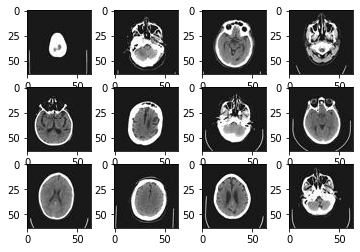

In [19]:
dir_name = os.path.join(train_dir,"HeadCT")
all_images = [os.path.join(dir_name, fname) for fname in os.listdir(dir_name)]
show_mri(all_images[:12])

### Pre-processing images

In [21]:
image_size = (32, 32, 3)
datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
training_set = datagen.flow_from_directory(train_dir, target_size=image_size[:2], batch_size=32, class_mode='categorical', shuffle=False)
validation_set = datagen.flow_from_directory(test_dir, target_size=image_size[:2], batch_size=32, class_mode='categorical', shuffle=False)

Found 58954 images belonging to 6 classes.
Found 21625 images belonging to 6 classes.


### Callbacks

In [23]:
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=7)
filepath = "modelMedicalMNIST.h5"
ckpt = ModelCheckpoint(filepath, monitor='acc', verbose=1,
save_best_only=True, mode='max')
rlp = ReduceLROnPlateau(monitor='acc', patience=3, verbose=1)

### CNN Model

In [24]:
def cnn(image_size, num_classes):
  classifier = Sequential()
  classifier.add(Conv2D(64, (5,5), input_shape=image_size, activation='relu', padding='same'))
  classifier.add(MaxPooling2D(pool_size= (2,2)))
  classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
  classifier.add(MaxPooling2D(pool_size = (2, 2)))
  classifier.add(Flatten())
  classifier.add(Dense(num_classes, activation = 'softmax'))
  classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
  return classifier

neuralnetwork_cnn = cnn(image_size, num_classes)
neuralnetwork_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 6)                 4

### Fitting

In [25]:
history = neuralnetwork_cnn.fit_generator( generator=training_set, validation_data=validation_set, callbacks=[es, ckpt, rlp], epochs = 5, )

Epoch 1/5


<ipython-input-25-5d513556557b>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = neuralnetwork_cnn.fit_generator( generator=training_set, validation_data=validation_set, callbacks=[es, ckpt, rlp], epochs = 5, )


1843/1843 [==============================] - ETA: 0s - loss: 0.1901 - acc: 0.9304
Epoch 1: acc improved from -inf to 0.93037, saving model to modelMedicalMNIST.h5
1843/1843 [==============================] - 313s 169ms/step - loss: 0.1901 - acc: 0.9304 - val_loss: 0.0333 - val_acc: 0.9902 - lr: 0.0010
Epoch 2/5
1843/1843 [==============================] - ETA: 0s - loss: 0.0763 - acc: 0.9847
Epoch 2: acc improved from 0.93037 to 0.98470, saving model to modelMedicalMNIST.h5
1843/1843 [==============================] - 302s 164ms/step - loss: 0.0763 - acc: 0.9847 - val_loss: 0.0139 - val_acc: 0.9970 - lr: 0.0010
Epoch 3/5
1843/1843 [==============================] - ETA: 0s - loss: 0.0449 - acc: 0.9879
Epoch 3: acc improved from 0.98470 to 0.98787, saving model to modelMedicalMNIST.h5
1843/1843 [==============================] - 302s 164ms/step - loss: 0.0449 - acc: 0.9879 - val_loss: 0.0146 - val_acc: 0.9964 - lr: 0.0010
Epoch 4/5
1843/1843 [==============================] - ETA: 0s - 

### Loss and accuracy graghs

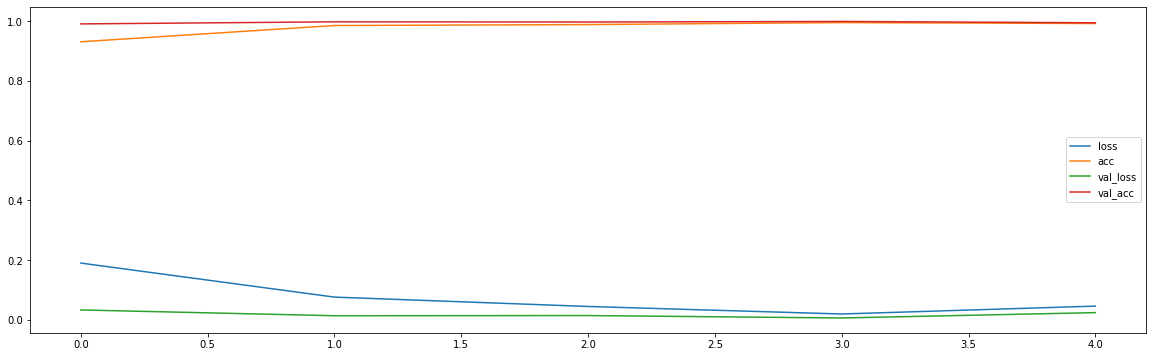

In [26]:
fig, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history).iloc[:, :-1].plot(ax=ax)

### Predicting on validation set

In [32]:
batch_size=32
pred=neuralnetwork_cnn.predict(validation_set,steps=306/batch_size)
predicted_class_indices=np.argmax(pred,axis=1)

labels = (validation_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

9/9 [==============================] - 1s 56ms/step


### Displaying the category of image and predicted image

In [37]:
filenames=validation_set.filenames[0]
results=pd.DataFrame({"Filename":filenames, "Predictions":predictions})

display(results.head(12))

,Filename,Predictions
0,AbdomenCT/000002.jpeg,AbdomenCT
1,AbdomenCT/000002.jpeg,AbdomenCT
2,AbdomenCT/000002.jpeg,AbdomenCT
3,AbdomenCT/000002.jpeg,AbdomenCT
4,AbdomenCT/000002.jpeg,AbdomenCT
5,AbdomenCT/000002.jpeg,AbdomenCT
6,AbdomenCT/000002.jpeg,AbdomenCT
7,AbdomenCT/000002.jpeg,AbdomenCT
8,AbdomenCT/000002.jpeg,AbdomenCT
9,AbdomenCT/000002.jpeg,AbdomenCT
